## Dataset Used : <a href="https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset?select=tags.csv">Movie  Lens Small Dataset</a>

In [1]:
import pandas as pd

df = pd.read_csv("datasets/ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Correcting indexes to be from 0 to n-1
For giving as valid inputs inside embedding layer

In [2]:
df['userIdCat'] = pd.Categorical(df.userId)
df['new_user_id'] = df.userIdCat.cat.codes
df.head()

,userId,movieId,rating,timestamp,userIdCat,new_user_id
0,1,1,4.0,964982703,1,0
1,1,3,4.0,964981247,1,0
2,1,6,4.0,964982224,1,0
3,1,47,5.0,964983815,1,0
4,1,50,5.0,964982931,1,0


In [3]:
df['movieIdCat'] = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieIdCat.cat.codes
df.head()

,userId,movieId,rating,timestamp,userIdCat,new_user_id,movieIdCat,new_movie_id
0,1,1,4.0,964982703,1,0,1,0
1,1,3,4.0,964981247,1,0,3,2
2,1,6,4.0,964982224,1,0,6,5
3,1,47,5.0,964983815,1,0,47,43
4,1,50,5.0,964982931,1,0,50,46


In [4]:
df.describe()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
count,100836.000000,100836.000000,100836.000000,1.008360e+05,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557,1.205946e+09,325.127564,3101.735561
std,182.618491,35530.987199,1.042529,2.162610e+08,182.618491,2627.050983
min,1.000000,1.000000,0.500000,8.281246e+08,0.000000,0.000000
25%,177.000000,1199.000000,3.000000,1.019124e+09,176.000000,900.000000
50%,325.000000,2991.000000,3.500000,1.186087e+09,324.000000,2252.000000
75%,477.000000,8122.000000,4.000000,1.435994e+09,476.000000,5095.250000
max,610.000000,193609.000000,5.000000,1.537799e+09,609.000000,9723.000000


As we can see from the min and max, the userId and movieId have been fixed to 0 to n-1 form

### Taking out the data we need

In [5]:
user_ids = df.new_user_id
movie_ids = df.new_movie_id
ratings = df.rating

In [6]:
N = len(user_ids)
M = len(movie_ids)
print(N, M)

100836 100836


### Creating the models

In [7]:
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten, Dense
from tensorflow.keras import Model

# Embedding Dimension
K = 20

In [8]:
# Model for user
u = Input(shape=(1,), name="user_input")
u_emb = Embedding(N, K, name="user_embedding")(u)        # output shape => (num_samples, 1, K)
u_emb = Flatten()(u_emb)          # output shape => (num_samples, K)

In [9]:
# Model for movie
m = Input(shape=(1,), name="movie_input")
m_emb = Embedding(M, K, name="movie_embedding")(m)
m_emb = Flatten()(m_emb)

In [10]:
# Combining the embeddings
x = Concatenate()([u_emb, m_emb])  # output shape => (num_samples, 2K)
x = Dense(256, activation='relu')(x)
x = Dense(1)(x)

In [11]:
model = Model(inputs = [u, m], outputs = x)
model.compile(loss='mse', optimizer='adam')

In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        2016720     user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 20)        2016720     movie_input[0][0]                
_______________________________________________________________________________________

### Splitting and Training

In [13]:
from random import shuffle

arr = list(zip(user_ids, movie_ids, ratings))
shuffle(arr)
user_ids, movie_ids, ratings = zip(*arr)

n = int(0.8*len(ratings))

train_user = user_ids[:n]
train_movie = movie_ids[:n]
train_ratings = ratings[:n]

test_user = user_ids[n:]
test_movie = movie_ids[n:]
test_ratings = ratings[n:]

In [14]:
import numpy as np

n_epochs = 25

r = model.fit(
    x = [np.asarray(train_user), np.asarray(train_movie)], 
    y = np.asarray(train_ratings), 
    epochs = n_epochs,
    batch_size = 1024,
    validation_data = ([np.asarray(test_user), np.asarray(test_movie)], np.asarray(test_ratings))
)

Epoch 1/25
79/79 [==============================] - 5s 58ms/step - loss: 6.4644 - val_loss: 1.0035
Epoch 2/25
79/79 [==============================] - 5s 58ms/step - loss: 0.8065 - val_loss: 0.7770
Epoch 3/25
79/79 [==============================] - 5s 57ms/step - loss: 0.7049 - val_loss: 0.7615
Epoch 4/25
79/79 [==============================] - 4s 55ms/step - loss: 0.6769 - val_loss: 0.7606
Epoch 5/25
79/79 [==============================] - 5s 59ms/step - loss: 0.6636 - val_loss: 0.7656
Epoch 6/25
79/79 [==============================] - 4s 51ms/step - loss: 0.6568 - val_loss: 0.7658
Epoch 7/25
79/79 [==============================] - 4s 51ms/step - loss: 0.6519 - val_loss: 0.7685
Epoch 8/25
79/79 [==============================] - 5s 57ms/step - loss: 0.6491 - val_loss: 0.7683
Epoch 9/25
79/79 [==============================] - 5s 61ms/step - loss: 0.6466 - val_loss: 0.7713
Epoch 10/25
79/79 [==============================] - 5s 63ms/step - loss: 0.6455 - val_loss: 0.7700
Epoch 11/

### Results

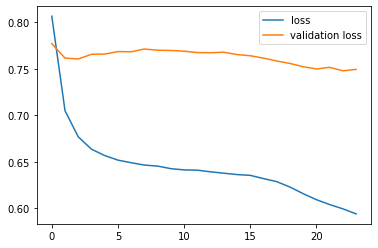

In [19]:
import matplotlib.pyplot as plt

# First value removal to remove the first sharp fall
# and get a clear diagram 
history = r.history
plt.plot(history['loss'][1:], label='loss')
plt.plot(history['val_loss'][1:], label='validation loss')
plt.legend()
plt.show()

In [20]:
v = history['val_loss'][-1]
print("Final validation loss : ", v)
print("RMSE : ", np.sqrt(v))

Final validation loss :  0.7493482232093811
RMSE :  0.8656490184880828
